# RISKADAPT demonstrations

Demonstrate different data sets that are of use for the RISKADAPT project.

This demo is related to deliverable D3.1 – Access to EO data.

http://riskadapt.eu/wp-content/uploads/2023/05/RISKADAPT_D3.1_v1.1_Access-to-EO-data.pdf

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

import geopandas as gpd
import regionmask

import cdsapi

imagery = OSM(cache=True)

In [2]:
shape = gpd.read_file('Drainage_basin/basin.shp')
# print(shape)
shape.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

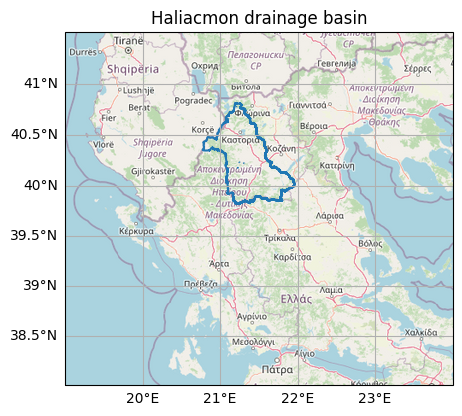

In [3]:
p0 = imagery.crs
p1 = ccrs.PlateCarree()
p2 = ccrs.epsg('3035')

fig, ax = plt.subplots(1, 1, figsize=(5, 5),  subplot_kw={'projection': p0})
ax.set_extent(np.r_[19.0, 24.0, 38, 41.5], crs=p1)
ax.add_image(imagery, 7, interpolation='spline36')
shape.to_crs(p0).boundary.plot(ax=ax)

gl = ax.gridlines(dms=False, draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
plt.title('Haliacmon drainage basin')
plt.show()

Mask xarray data to the shape

In [4]:
bb = shape.to_crs('EPSG:4326').bounds.values[0]
shape.to_crs('EPSG:4326').bounds

,minx,miny,maxx,maxy
0,20.776522,39.818271,21.959666,40.809015


In [5]:
cdsparams = {
    'format': 'grib',
    'variable': 'total_precipitation',
    # 'product_type': 'monthly_averaged_reanalysis_by_hour_of_day',
    'product_type': 'monthly_averaged_reanalysis',
    # 'year': ['2020'],
    # 'month': ['06'],
    # 'time': '12:00',
    'year': [f'{n}' for n in range(2001, 2022)],
    'month': [f'{n:02d}' for n in range(1, 13)],
    'time': '00:00',
    # north, west, south, east
    # 'area': [72.0, -25.0, 25.6, 40],
    'area': [bb[3]+0.1, bb[0]-0.1, bb[1]-0.1, bb[2]+0.1],
}
# cdsparams

In [6]:
c = cdsapi.Client()
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    cdsparams,
    'data/ERA5-Haliacmon_precipitation.grib')

2023-07-20 11:08:59,695 INFO Welcome to the CDS
2023-07-20 11:08:59,696 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-07-20 11:08:59,932 INFO Request is queued
2023-07-20 11:09:00,996 INFO Request is running
2023-07-20 11:10:15,386 INFO Request is completed
2023-07-20 11:10:15,387 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.mars.internal-1689840540.6501455-10043-12-d669d5d3-b8bf-4a78-9965-6fd3e1be3a33.grib to ERA5-Haliacmon_precipitation.grib (59.1K)
2023-07-20 11:10:15,783 INFO Download rate 149.3K/s


Result(content_length=60480,content_type=application/x-grib,location=https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.mars.internal-1689840540.6501455-10043-12-d669d5d3-b8bf-4a78-9965-6fd3e1be3a33.grib)

In [9]:
ds = xr.open_dataset('data/ERA5-Haliacmon_precipitation.grib')
ds

<xarray.Dataset>
Dimensions:     (time: 252, latitude: 5, longitude: 6)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2000-12-31T18:00:00 ... 2021-11-30T18:0...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 40.72 40.47 40.22 39.97 39.72
  * longitude   (longitude) float64 20.68 20.93 21.18 21.43 21.68 21.93
    valid_time  (time) datetime64[ns] ...
Data variables:
    tp          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-07-20T11:10 GRIB to CDM+CF via cfgrib-0.9.1...

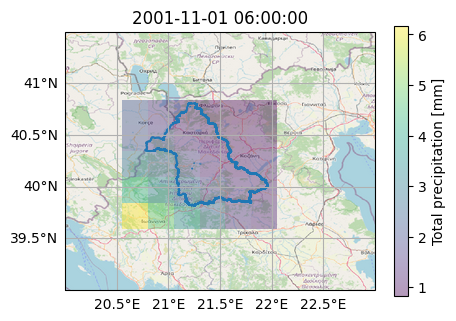

In [10]:
da = ds.isel(time=10)['tp'] * 1000
da.attrs['units'] = 'mm'
p0 = imagery.crs
#p1 = ccrs.epsg('4326')
p1 = ccrs.PlateCarree()
p2 = ccrs.epsg('3035')

fig, ax = plt.subplots(1, 1, figsize=(5, 5),  subplot_kw={'projection': p1})
ax.set_extent(np.r_[20.0, 23.0, 39, 41.5], crs=p1)
ax.add_image(imagery, 8, interpolation='spline36')
shape.to_crs(p1).boundary.plot(ax=ax, transform=p1)
m = ax.pcolormesh(da.longitude, da.latitude, da, transform=p1, alpha=0.4)

gl = ax.gridlines(dms=False, draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
plt.title(pd.to_datetime(da.valid_time.values))
fig.colorbar(m, shrink=0.7, label='Total precipitation [mm]')
plt.show()

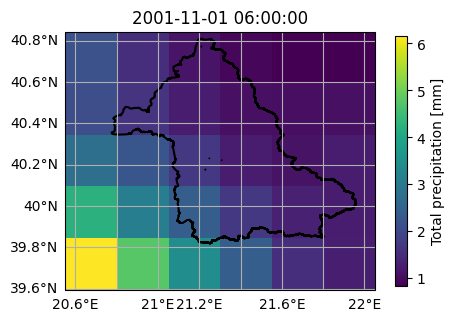

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5),  subplot_kw={'projection': p1})
m = ax.pcolormesh(da.longitude, da.latitude, da, transform=p1)
shape.to_crs(p1).boundary.plot(ax=ax, transform=p1, color='black')

gl = ax.gridlines(dms=False, draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
plt.title(pd.to_datetime(da.valid_time.values))
fig.colorbar(m, shrink=0.65, label='Total precipitation [mm]')
plt.show()

"Downscale" Just by nearest neighbour interpolation.

In [13]:
lat = ds.latitude.values
lat = np.linspace(lat[0], lat[-1], lat.size*2)
lon = ds.longitude.values
lon = np.linspace(lon[0], lon[-1], lon.size*2)

#lon = ds.longitude.values
#lat = ds.latitude.values
mask = regionmask.mask_geopandas(shape.to_crs('EPSG:4326'), lon, lat, lon_name='longitude', lat_name='latitude')

ds2 = ds.reindex(longitude=lon, latitude=lat, method='nearest')
da2 = da.reindex(longitude=lon, latitude=lat, method='nearest')

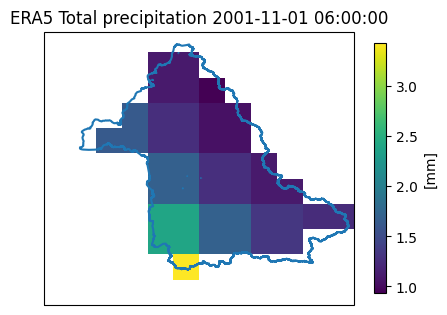

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5),  subplot_kw={'projection': p1})
da2.where(mask == 0).plot(cbar_kwargs={'shrink': 0.65, 'label': '[mm]'})
shape.to_crs(p1).boundary.plot(ax=ax, transform=p1)
plt.title(f'ERA5 Total precipitation {pd.to_datetime(da2.valid_time.values)}')
plt.show()

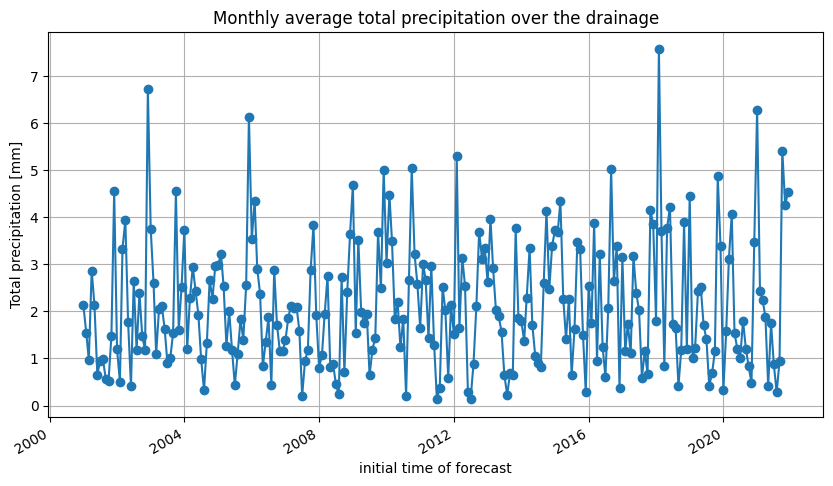

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(ds2['tp']*1000).where(mask == 0).mean(dim=['latitude', 'longitude']).plot(marker='o')
plt.title('Monthly average total precipitation over the drainage')
plt.ylabel('Total precipitation [mm]')
plt.grid()
plt.show()

Next download Euro CORDEX historical experiment to check

In [16]:
import cdsapi

c = cdsapi.Client()
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'historical',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'monthly_mean',
        'variable': 'mean_precipitation_flux',
        'rcm_model': 'mohc_hadrem3_ga7_05',
        'gcm_model': 'cnrm_cerfacs_cm5',
        'ensemble_member': 'r1i1p1',
        'start_year': '2001',
        'end_year': '2010',
    },
    '/tmp/cordex.zip')

2023-07-20 11:12:26,742 INFO Welcome to the CDS
2023-07-20 11:12:26,742 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2023-07-20 11:12:27,046 INFO Request is queued
2023-07-20 11:12:28,111 INFO Request is running
2023-07-20 11:13:16,802 INFO Request is completed
2023-07-20 11:13:16,803 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data1/dataset-projections-cordex-domains-single-levels-9b4ebfe9-8990-49cb-ae03-094f171a86d3.zip to /tmp/cordex.zip (70.6M)
2023-07-20 11:13:34,299 INFO Download rate 4M/s     


Result(content_length=74036266,content_type=application/zip,location=https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data1/dataset-projections-cordex-domains-single-levels-9b4ebfe9-8990-49cb-ae03-094f171a86d3.zip)

In [17]:
# after unzipping to data forlder
file = 'data/pr_EUR-11_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_MOHC-HadREM3-GA7-05_v2_mon_200101-201012.nc'
cordex = xr.open_dataset(file)
cordex

<xarray.Dataset>
Dimensions:                     (rlat: 412, rlon: 424, time: 120, bnds: 2,
                                 vertices: 4)
Coordinates:
    latitude                    (rlat, rlon) float64 ...
    longitude                   (rlat, rlon) float64 ...
  * rlat                        (rlat) float64 -23.38 -23.26 ... 21.72 21.83
  * rlon                        (rlon) float64 -28.38 -28.27 ... 18.04 18.15
  * time                        (time) datetime64[ns] 2001-01-16T12:00:00 ......
Dimensions without coordinates: bnds, vertices
Data variables:
    pr                          (time, rlat, rlon) float32 ...
    rlat_bnds                   (rlat, bnds) float64 ...
    rlon_bnds                   (rlon, bnds) float64 ...
    rotated_latitude_longitude  int32 ...
    time_bnds                   (time, bnds) datetime64[ns] ...
    vertices_latitude           (rlat, rlon, vertices) float64 ...
    vertices_longitude          (rlat, rlon, vertices) float64 ...
Attributes: (12/22)
    model_id:                       MOHC-HadREM3-GA7-05
    driving_experiment_name:        historical
    creation_date:                  2020-11-14T01:08:21Z
    project_id:                     CORDEX
    experiment:                     historical run using  CNRM-CERFACS-CNRM-C...
    institution:                    MetOffice, Hadley Centre, UK
    ...                             ...
    driving_model_id:               CNRM-CERFACS-CNRM-CM5
    tracking_id:                    hdl:21.14103/59ae51e0-1b9b-4e3f-953b-fc6f...
    institute_id:                   MOHC
    frequency:                      mon
    driving_experiment_comment:     Known issue correction: this simulation (...
    driving_scenario_comment:       historical 1951-2005, rcp85 2006-2010

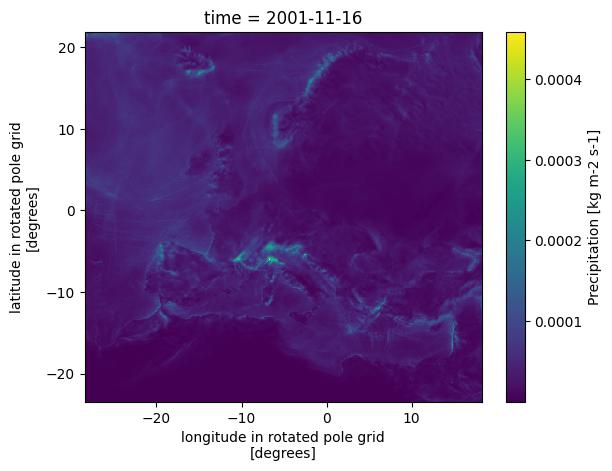

In [19]:
cordex.isel(time=10)['pr'].plot()
plt.show()

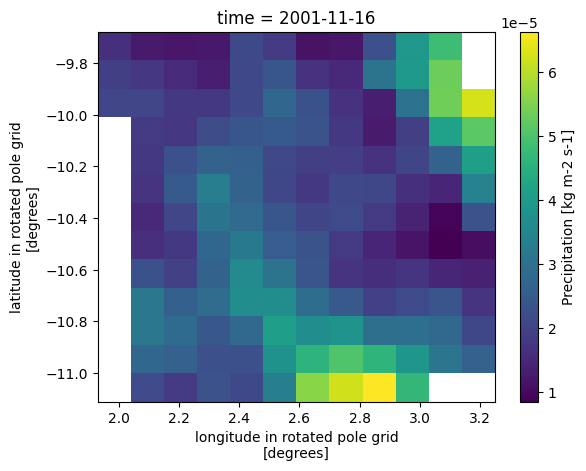

In [21]:
d = 0.2
cmask = ((cordex.longitude >= bb[0] - d) & (cordex.longitude <= bb[2] + d) &
 (cordex.latitude >= bb[1] - d) & (cordex.latitude <= bb[3] + d))

cordex.where(cmask, drop=True).isel(time=10)['pr'].plot()
plt.show()

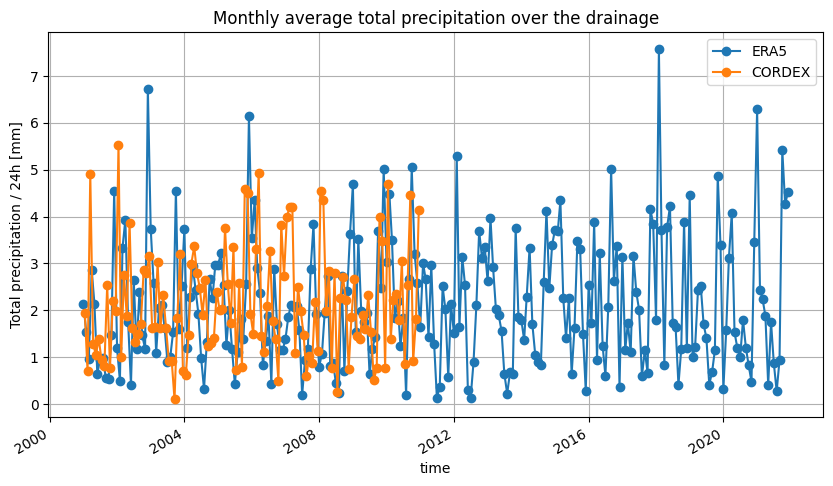

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(ds2['tp']*1000).where(mask == 0).mean(dim=['latitude', 'longitude']).plot(marker='o', label='ERA5')
z = cordex.where(cmask, drop=True)['pr'].mean(dim=['rlat', 'rlon']) * 86400
z.plot(marker='o', label='CORDEX')
plt.title('Monthly average total precipitation over the drainage')
plt.ylabel('Total precipitation / 24h [mm]')
plt.grid()
plt.legend()
plt.show()

E-OBS gridded observations data set.

In [24]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'format': 'zip',
        'product_type': 'ensemble_mean',
        'variable': 'precipitation_amount',
        'grid_resolution': '0.1deg',
        'period': '2011_2022',
        'version': '26.0e',
    },
    '/tmp/e-obs.zip')

2023-07-20 11:16:05,758 INFO Welcome to the CDS
2023-07-20 11:16:05,758 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-europe
2023-07-20 11:16:05,943 INFO Request is queued
2023-07-20 11:16:07,010 INFO Request is running
2023-07-20 11:17:59,923 INFO Request is completed
2023-07-20 11:17:59,924 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data5/dataset-insitu-gridded-observations-europe-407e658f-2915-43fa-8217-d62f68b4a967.zip to /tmp/e-obs.zip (234.6M)
2023-07-20 11:18:55,657 INFO Download rate 4.2M/s  


Result(content_length=245945823,content_type=application/zip,location=https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data5/dataset-insitu-gridded-observations-europe-407e658f-2915-43fa-8217-d62f68b4a967.zip)

In [25]:
eobs = xr.open_dataset('data/rr_ens_mean_0.1deg_reg_2011-2022_v26.0e.nc')
eobs

<xarray.Dataset>
Dimensions:    (latitude: 465, longitude: 705, time: 4199)
Coordinates:
  * latitude   (latitude) float64 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2022-06-30
Data variables:
    rr         (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  26.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Sep 30 08:26:32 2022: ncks --no-abc -d time,22280,264...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....

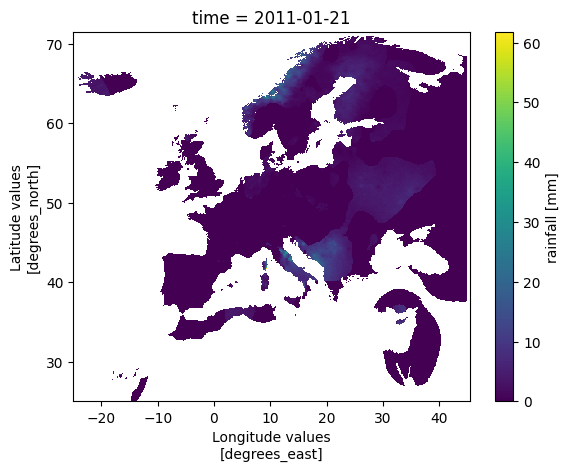

In [26]:
emask = regionmask.mask_geopandas(shape.to_crs('EPSG:4326'),
                                  eobs.longitude.values, eobs.latitude.values,
                                  lon_name='longitude', lat_name='latitude')

eobs.isel(time=20)['rr'].plot()
plt.show()

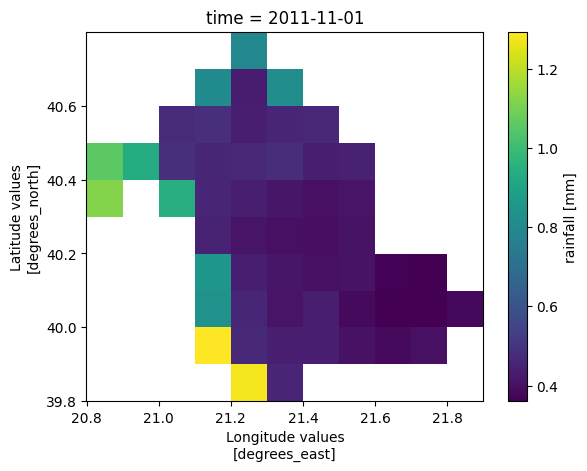

In [27]:
rrmonthly = eobs['rr'].resample(time='1MS').mean('time')
rrmonthly.where(emask==0, drop=True).isel(time=10).plot()
plt.show()

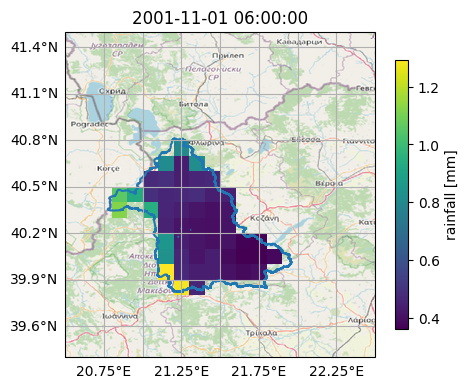

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5),  subplot_kw={'projection': p1})
# ax.set_extent(np.r_[20.0, 23.0, 39, 41.5], crs=p1)
ax.set_extent(np.r_[20.5, 22.5, 39.4, 41.5], crs=p1)
ax.add_image(imagery, 8, interpolation='spline36')
shape.to_crs(p1).boundary.plot(ax=ax, transform=p1)
m = rrmonthly.where(emask==0, drop=True).isel(time=10).plot(cbar_kwargs={'shrink': 0.7})
gl = ax.gridlines(dms=False, draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False
plt.title(pd.to_datetime(da.valid_time.values))
# fig.colorbar(m, shrink=0.7, label='Total precipitation [mm]')
plt.show()

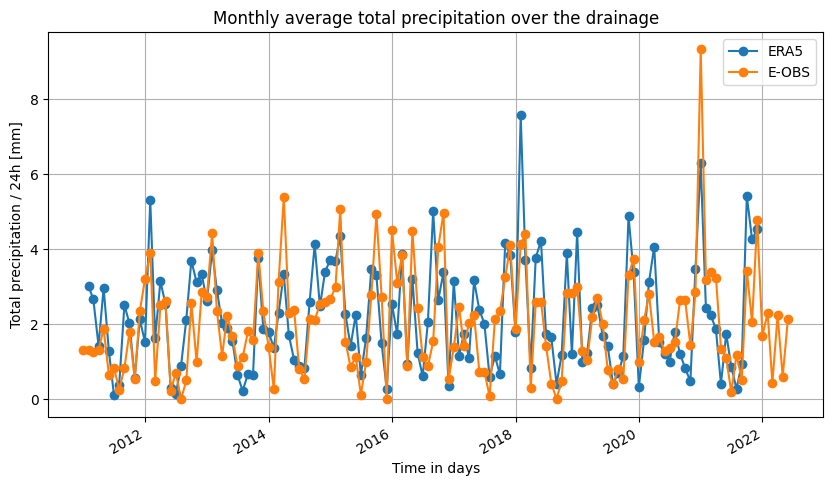

In [29]:
# ERA vs E-OBS
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
((ds2['tp']*1000).where((mask == 0) & (ds2.time > np.datetime64('2011-01-01'))).
 mean(dim=['latitude', 'longitude']).plot(marker='o', label='ERA5'))
rrmonthly.where(emask==0, drop=True).mean(['latitude', 'longitude']).plot(marker='o', label='E-OBS')
#z = cordex.where(cmask, drop=True)['pr'].mean(dim=['rlat', 'rlon']) * 86400
#z.plot(marker='o')
plt.title('Monthly average total precipitation over the drainage')
plt.ylabel('Total precipitation / 24h [mm]')
plt.grid()
plt.legend()
plt.show()
